<a href="https://colab.research.google.com/github/eedreamer/training-data-analyst/blob/master/Sequence_to_Sequence_Learning_with_Tensor2Tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to Sequence Learning with Tensor2Tensor


This notebook was created for PhD Open lectures given in June 2018 at the University of Warsaw. The slides for the lectures are available [here](http://phdopen.mimuw.edu.pl/lato18/w5s/DeepLearning.pdf) and the full recording [here on YouTube](https://www.youtube.com/channel/UCvMN-HLvvVa6lUXijCKFlqQ) - take a look at it if you need more explanation!

In [0]:
# Install deps.
!pip install -q -U tensor2tensor
!pip install -q tensorflow matplotlib


In [0]:
#t2t-trainer  --generate_data \
#  --data_dir=~/t2t_data \
#  --output_dir=~/t2t_train/mnist \
 # --problem=image_mnist \
 # --model=shake_shake \
 # --hparams_set=shake_shake_quick \
 # --train_steps=1000 \
 # --eval_steps=100

In [0]:
# Imports we need.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections
import random
import six

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_attention
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics
from tensor2tensor.utils import learning_rate
from tensor2tensor.utils import optimize

# TF session
sess = tf.Session()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

# Download MNIST and inspect it

In [25]:
# Fetch the MNIST problem
print(problems.available())
mnist_problem = problems.problem("image_mnist")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
mnist_problem.generate_data(data_dir, tmp_dir)

['algorithmic_addition_binary40', 'algorithmic_addition_decimal40', 'algorithmic_cipher_shift200', 'algorithmic_cipher_shift5', 'algorithmic_cipher_vigenere200', 'algorithmic_cipher_vigenere5', 'algorithmic_identity_binary40', 'algorithmic_identity_decimal40', 'algorithmic_multiplication_binary40', 'algorithmic_multiplication_decimal40', 'algorithmic_reverse_binary40', 'algorithmic_reverse_binary40_test', 'algorithmic_reverse_decimal40', 'algorithmic_reverse_nlplike32k', 'algorithmic_reverse_nlplike8k', 'algorithmic_shift_decimal40', 'algorithmic_sort_problem', 'audio_timit_characters_tune', 'audio_timit_tokens8k_test', 'audio_timit_tokens8k_tune', 'babi_qa_concat_all_tasks_10k', 'babi_qa_concat_all_tasks_1k', 'babi_qa_concat_task10_10k', 'babi_qa_concat_task10_1k', 'babi_qa_concat_task11_10k', 'babi_qa_concat_task11_1k', 'babi_qa_concat_task12_10k', 'babi_qa_concat_task12_1k', 'babi_qa_concat_task13_10k', 'babi_qa_concat_task13_1k', 'babi_qa_concat_task14_10k', 'babi_qa_concat_task14_

INFO:tensorflow:Reading data files from /root/t2t/data/image_mnist-train*
INFO:tensorflow:partition: 0 num_data_files: 10
:::MLPv0.5.0 transformer 1541964125.124738455 (<ipython-input-26-55840b779871>:1) input_order
Label: 2


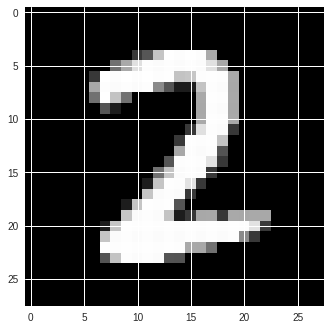

In [26]:
# Now let's see the training MNIST data as Tensors.
mnist_data = mnist_problem.dataset(Modes.TRAIN, data_dir)
mnist_example_tensors = mnist_data.make_one_shot_iterator().get_next()
mnist_example = sess.run(mnist_example_tensors)
image = mnist_example["inputs"]
label = mnist_example["targets"]

plt.imshow(image[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label)

# Basic MNIST model.

In [0]:
# One-off all code together.

# Data.
BATCH_SIZE = 100
data_batches = mnist_data.repeat().batch(BATCH_SIZE).make_one_shot_iterator()
batch = data_batches.get_next()
x, y = batch["inputs"], batch["targets"]
x = tf.reshape(x, [BATCH_SIZE, 28*28])  # Height and width on channels.
y = tf.squeeze(y, axis=1)  # Bogus dimension.
# Model.
hidden_size = 128
h = tf.layers.dense(x, hidden_size, activation=tf.nn.relu, name="hidden")
o = tf.layers.dense(h, 10, activation=tf.nn.relu, name="output")
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
loss_t, accuracy_t = tf.reduce_mean(loss), tf.reduce_mean(accuracy)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(loss_t)
sess.run(tf.global_variables_initializer())

In [28]:
# Train.
num_steps = 1200  #  2 epochs on 60K examples.
for step in range(num_steps):
  _, loss, accuracy = sess.run([train_op, loss_t, accuracy_t])
  if step % 100 == 0:
    print("Step %d loss %.4f accuracy %.2f" % (step, loss, accuracy))

Step 0 loss 2.5756 accuracy 0.07
Step 100 loss 0.2459 accuracy 0.94
Step 200 loss 0.2943 accuracy 0.92
Step 300 loss 0.1252 accuracy 0.97
Step 400 loss 0.2061 accuracy 0.95
Step 500 loss 0.1120 accuracy 0.98
Step 600 loss 0.1161 accuracy 0.98
Step 700 loss 0.1714 accuracy 0.95
Step 800 loss 0.0421 accuracy 0.98
Step 900 loss 0.0635 accuracy 0.98
Step 1000 loss 0.0903 accuracy 0.98
Step 1100 loss 0.0365 accuracy 0.99


In [29]:
# Once again, all refactored and with reset.

# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Data.
problem = problems.problem("image_mnist")
problem.generate_data(data_dir, tmp_dir)
BATCH_SIZE = 100
train_data = problem.dataset(Modes.TRAIN, data_dir)
train_batches = train_data.repeat().batch(BATCH_SIZE)
train_batch = train_batches.make_one_shot_iterator().get_next()
eval_data = problem.dataset(Modes.EVAL, data_dir)
eval_batches = eval_data.repeat().batch(BATCH_SIZE)
eval_batch = eval_batches.make_one_shot_iterator().get_next()

# Model
def model(batch, mode):
  with tf.variable_scope("mymodel", reuse=mode == Modes.EVAL):
    # Inputs.
    x, y = batch["inputs"], batch["targets"]
    x = tf.reshape(x, [BATCH_SIZE, 28*28])  # Height and width on channels.
    y = tf.squeeze(y, axis=1)  # Bogus dimension.
    # Body.
    hidden_size = 128
    h = tf.layers.dense(x, hidden_size, activation=tf.nn.relu, name="hidden")
    o = tf.layers.dense(h, 10, activation=tf.nn.relu, name="output")
    # Loss and accuracy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
    accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

# Model for train.
train_loss, train_accuracy = model(train_batch, Modes.TRAIN)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(train_loss)
# Model for eval.
eval_loss, eval_accuracy = model(eval_batch, Modes.EVAL)

INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Skipping generator because outputs files exists at ['/root/t2t/data/image_mnist-unshuffled-train-00000-of-00010', '/root/t2t/data/image_mnist-unshuffled-train-00001-of-00010', '/root/t2t/data/image_mnist-unshuffled-train-00002-of-00010'

In [30]:
# Train.
sess.run(tf.global_variables_initializer())
num_steps = 2400  #  4 epochs on 60K examples.
for step in range(num_steps + 1):
  _, loss, accuracy = sess.run([train_op, train_loss, train_accuracy])
  if step % 100 == 0:
    print("Step %d train loss %.4f accuracy %.2f" % (step, loss, accuracy))
    loss, accuracy = sess.run([eval_loss, eval_accuracy])
    print("Step %d eval loss %.4f accuracy %.2f" % (step, loss, accuracy))


Step 0 train loss 2.7247 accuracy 0.05
Step 0 eval loss 2.4815 accuracy 0.13
Step 100 train loss 0.1811 accuracy 0.92
Step 100 eval loss 0.2622 accuracy 0.93
Step 200 train loss 0.3427 accuracy 0.91
Step 200 eval loss 0.2392 accuracy 0.94
Step 300 train loss 0.1810 accuracy 0.94
Step 300 eval loss 0.1942 accuracy 0.95
Step 400 train loss 0.1553 accuracy 0.95
Step 400 eval loss 0.2462 accuracy 0.92
Step 500 train loss 0.1197 accuracy 0.96
Step 500 eval loss 0.0966 accuracy 0.98
Step 600 train loss 0.2403 accuracy 0.92
Step 600 eval loss 0.0692 accuracy 0.99
Step 700 train loss 0.3368 accuracy 0.93
Step 700 eval loss 0.0501 accuracy 0.99
Step 800 train loss 0.0791 accuracy 0.97
Step 800 eval loss 0.0665 accuracy 0.99
Step 900 train loss 0.1397 accuracy 0.94
Step 900 eval loss 0.1421 accuracy 0.97
Step 1000 train loss 0.0739 accuracy 0.96
Step 1000 eval loss 0.2016 accuracy 0.94
Step 1100 train loss 0.1279 accuracy 0.95
Step 1100 eval loss 0.0561 accuracy 0.99
Step 1200 train loss 0.1501 

# Simple sequence models

In [31]:
def generator(l):
  inputs = list(np.random.randint(2, size=l))
  even = [x for i, x in enumerate(inputs) if i % 2 == 0]
  repeated = [[x, x] for x in even]
  targets = [z for p in repeated for z in p]
  yield {"inputs": inputs, "targets": targets}

generator1 = lambda: generator(10)
generator2 = lambda: generator(20)

print(six.next(generator(8)))

{'inputs': [0, 0, 1, 0, 0, 0, 0, 1], 'targets': [0, 0, 1, 1, 0, 0, 0, 0]}


In [0]:
# Sequence model with 1 conv layer.

# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Data.
types = {"inputs": tf.int64, "targets": tf.int64}
shapes = {"inputs": tf.TensorShape([None]), "targets": tf.TensorShape([None])}

train_data = tf.data.Dataset.from_generator(
    generator2, output_types=types, output_shapes=shapes)
eval_data = tf.data.Dataset.from_generator(
    generator2, output_types=types, output_shapes=shapes)
BATCH_SIZE = 100
train_batches = train_data.repeat().batch(BATCH_SIZE)
train_batch = train_batches.make_one_shot_iterator().get_next()
eval_batches = eval_data.repeat().batch(BATCH_SIZE)
eval_batch = eval_batches.make_one_shot_iterator().get_next()

# Model
def model(batch, mode):
  with tf.variable_scope("mymodel", reuse=mode == Modes.EVAL):
    # Inputs.
    x, y = batch["inputs"], batch["targets"]
    x = tf.reshape(x, [BATCH_SIZE, -1, 1])
    y = tf.reshape(y, [BATCH_SIZE, -1, 1])
    x_hot = tf.one_hot(x, 2)  # From ints to 1-hot vectors.
    y_hot = tf.one_hot(y, 2)
    x = tf.layers.dense(x_hot, 32, name="embedding_x")
    y_emb = tf.layers.dense(y_hot, 32, name="embedding_y")
    # Exercise: try enabling the 2 lines below.
    positions = tf.get_variable("positions", [1, 20, 1, 32])
    x += positions[:, :tf.shape(x)[1], :, :]
    # Body.
    hidden_size = 32
    h = tf.layers.conv2d(x, hidden_size, (3, 1),
                         padding="same", activation=tf.nn.relu, name="hidden")
    o = tf.layers.conv2d(h, 2, (1, 1),
                         padding="same", name="output")
    # Loss and accuracy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
    accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

# Model for train.
train_loss, train_accuracy = model(train_batch, Modes.TRAIN)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(train_loss)
# Model for eval.
eval_loss, eval_accuracy = model(eval_batch, Modes.EVAL)

In [33]:
# Train.
sess.run(tf.global_variables_initializer())
num_steps = 200
for step in range(num_steps + 1):
  _, loss, accuracy = sess.run([train_op, train_loss, train_accuracy])
  if step % 10 == 0:
    print("Step %d train loss %.4f accuracy %.2f" % (step, loss, accuracy))
    loss, accuracy = sess.run([eval_loss, eval_accuracy])
    print("Step %d eval loss %.4f accuracy %.2f" % (step, loss, accuracy))

Step 0 train loss 0.6712 accuracy 0.55
Step 0 eval loss 0.6614 accuracy 0.57
Step 10 train loss 0.5411 accuracy 0.79
Step 10 eval loss 0.5232 accuracy 0.80
Step 20 train loss 0.4530 accuracy 0.77
Step 20 eval loss 0.4389 accuracy 0.77
Step 30 train loss 0.3878 accuracy 0.80
Step 30 eval loss 0.3870 accuracy 0.80
Step 40 train loss 0.3483 accuracy 0.83
Step 40 eval loss 0.3505 accuracy 0.86
Step 50 train loss 0.3260 accuracy 0.89
Step 50 eval loss 0.3269 accuracy 0.89
Step 60 train loss 0.3143 accuracy 0.95
Step 60 eval loss 0.3165 accuracy 0.96
Step 70 train loss 0.2861 accuracy 0.96
Step 70 eval loss 0.2796 accuracy 0.97
Step 80 train loss 0.2347 accuracy 1.00
Step 80 eval loss 0.2369 accuracy 1.00
Step 90 train loss 0.2047 accuracy 1.00
Step 90 eval loss 0.1931 accuracy 1.00
Step 100 train loss 0.1562 accuracy 1.00
Step 100 eval loss 0.1573 accuracy 1.00
Step 110 train loss 0.1135 accuracy 1.00
Step 110 eval loss 0.1054 accuracy 1.00
Step 120 train loss 0.0687 accuracy 1.00
Step 120 

# Autoregressive sequence models

In [34]:
def generator(l):
  inputs = list(np.random.randint(2, size=l))
  even = [x for i, x in enumerate(inputs) if i % 2 == 0]
  repeated = [[x, x] for x in even]
  targets1 = [z for p in repeated for z in p]
  targets2 = inputs
  targets = random.choice([targets1, targets2])
  yield {"inputs": inputs, "targets": targets}

generator1 = lambda: generator(10)
generator2 = lambda: generator(20)

print(six.next(generator(6)))

{'inputs': [1, 0, 0, 0, 0, 1], 'targets': [1, 1, 0, 0, 0, 0]}


In [0]:
# Sequence model with 1 conv layer.

# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Data.
types = {"inputs": tf.int64, "targets": tf.int64}
shapes = {"inputs": tf.TensorShape([None]), "targets": tf.TensorShape([None])}

train_data = tf.data.Dataset.from_generator(
    generator1, output_types=types, output_shapes=shapes)
eval_data = tf.data.Dataset.from_generator(
    generator2, output_types=types, output_shapes=shapes)
BATCH_SIZE = 100
train_batches = train_data.repeat().batch(BATCH_SIZE)
train_batch = train_batches.make_one_shot_iterator().get_next()
eval_batches = eval_data.repeat().batch(BATCH_SIZE)
eval_batch = eval_batches.make_one_shot_iterator().get_next()

# Model
def model(batch, mode):
  with tf.variable_scope("mymodel", reuse=mode == Modes.EVAL):
    # Inputs.
    x, y = batch["inputs"], batch["targets"]
    x = tf.reshape(x, [BATCH_SIZE, -1, 1])
    y = tf.reshape(y, [BATCH_SIZE, -1, 1])
    x_hot = tf.one_hot(x, 2)  # From ints to 1-hot vectors.
    y_hot = tf.one_hot(y, 2)
    x = tf.layers.dense(x_hot, 32, name="embedding_x")
    y_emb = tf.layers.dense(y_hot, 32, name="embedding_y")
    positions = tf.scan(lambda a, z: tf.layers.dense(a, 32),
                        tf.transpose(x, [1, 0, 2, 3]))
    positions = tf.transpose(positions, [1, 0, 2, 3])
    x += positions
    # Body.
    hidden_size = 32
    h = tf.layers.conv2d(x, hidden_size, (3, 1),
                         padding="same", activation=tf.nn.relu, name="hidden")
    # Autoregressive part.
    y_shifted = common_layers.shift_right(y_emb)
    h += y_shifted
    # Attention.
    h = tf.expand_dims(tf.squeeze(h, axis=2), axis=1)
    q = tf.layers.dense(h, 32, name="q")
    k = tf.layers.dense(h, 32, name="k")
    v = tf.layers.dense(h, 32, name="v")
    bias = common_attention.attention_bias_lower_triangle(
              common_layers.shape_list(h)[1])
    h += common_attention.dot_product_attention(q, k, v, bias)
    h = tf.reshape(h, tf.shape(x))
    # Logits.
    o = tf.layers.conv2d(h, 2, (1, 1),
                         padding="same", name="output")
    # Loss and accuracy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
    accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

# Model for train.
train_loss, train_accuracy = model(train_batch, Modes.TRAIN)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(train_loss)
# Model for eval.
eval_loss, eval_accuracy = model(eval_batch, Modes.EVAL)

In [37]:
# Train.
sess.run(tf.global_variables_initializer())
num_steps = 200
for step in range(num_steps + 1):
  _, loss, accuracy = sess.run([train_op, train_loss, train_accuracy])
  if step % 10 == 0:
    print("Step %d train loss %.4f accuracy %.2f" % (step, loss, accuracy))
    loss, accuracy = sess.run([eval_loss, eval_accuracy])
    print("Step %d eval loss %.4f accuracy %.2f" % (step, loss, accuracy))

Step 0 train loss 0.6622 accuracy 0.63
Step 0 eval loss 0.6525 accuracy 0.62
Step 10 train loss 0.4566 accuracy 0.77
Step 10 eval loss 0.4730 accuracy 0.76
Step 20 train loss 0.2775 accuracy 0.90
Step 20 eval loss 0.3294 accuracy 0.86
Step 30 train loss 0.2479 accuracy 0.87
Step 30 eval loss 0.2958 accuracy 0.85
Step 40 train loss 0.2371 accuracy 0.88
Step 40 eval loss 0.2306 accuracy 0.90
Step 50 train loss 0.1727 accuracy 0.92
Step 50 eval loss 0.2082 accuracy 0.91
Step 60 train loss 0.1419 accuracy 0.94
Step 60 eval loss 0.1768 accuracy 0.92
Step 70 train loss 0.0960 accuracy 0.96
Step 70 eval loss 0.1323 accuracy 0.94
Step 80 train loss 0.0674 accuracy 0.98
Step 80 eval loss 0.0816 accuracy 0.97
Step 90 train loss 0.0419 accuracy 0.99
Step 90 eval loss 0.1599 accuracy 0.95
Step 100 train loss 0.0278 accuracy 0.99
Step 100 eval loss 0.0752 accuracy 0.98
Step 110 train loss 0.0314 accuracy 0.99
Step 110 eval loss 0.2141 accuracy 0.95
Step 120 train loss 0.0269 accuracy 0.99
Step 120 

# Run pre-trained translation Transformer model.

In [39]:
# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Fetch the problem
# problems.available()
ende_problem = problems.problem("translate_ende_wmt32k")

# Copy the vocab file locally so we can encode inputs and decode model outputs
# All vocabs are stored on GCS
vocab_name = "vocab.translate_ende_wmt32k.32768.subwords"
vocab_file = os.path.join(gs_data_dir, vocab_name)
!gsutil cp {vocab_file} {data_dir}
!head -n 20 {data_dir}/{vocab_name}
# Get the encoders from the problem
encoders = ende_problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(tf.constant(inputs), [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

Copying gs://tensor2tensor-data/vocab.translate_ende_wmt32k.32768.subwords...
/ [1 files][313.8 KiB/313.8 KiB]                                                
Operation completed over 1 objects/313.8 KiB.                                    
'<pad>_'
'<EOS>_'
', _'
'._'
'the_'
'_'
'in_'
'of_'
'and_'
'to_'
'die_'
'der_'
'und_'
'a_'
's_'
'-_'
'is_'
'that_'
'zu_'
'for_'


In [0]:
# # Generate and view the data
# # This cell is commented out because WMT data generation can take hours

# ende_problem.generate_data(data_dir, tmp_dir)
# example = tfe.Iterator(ende_problem.dataset(Modes.TRAIN, data_dir)).next()
# inputs = [int(x) for x in example["inputs"].numpy()] # Cast to ints.
# targets = [int(x) for x in example["targets"].numpy()] # Cast to ints.



# # Example inputs as int-tensor.
# print("Inputs, encoded:")
# print(inputs)
# print("Inputs, decoded:")
# # Example inputs as a sentence.
# print(decode(inputs))
# # Example targets as int-tensor.
# print("Targets, encoded:")
# print(targets)
# # Example targets as a sentence.
# print("Targets, decoded:")
# print(decode(targets))

In [40]:
# Create hparams and the model
# registry.list_models()
model_name = "transformer"
hparams_set = "transformer_base"

hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name="translate_ende_wmt32k")

# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.
translate_model = registry.model(model_name)(hparams, Modes.EVAL)

INFO:tensorflow:Setting T2TModel mode to 'eval'
INFO:tensorflow:Setting hparams.dropout to 0.0
INFO:tensorflow:Setting hparams.label_smoothing to 0.0
INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0
INFO:tensorflow:Setting hparams.symbol_dropout to 0.0
INFO:tensorflow:Setting hparams.attention_dropout to 0.0
INFO:tensorflow:Setting hparams.relu_dropout to 0.0


In [41]:
# Copy the pretrained checkpoint locally
ckpt_name = "transformer_ende_test"
gs_ckpt = os.path.join(gs_ckpt_dir, ckpt_name)
!gsutil -q cp -R {gs_ckpt} {checkpoint_dir}
ckpt_path = tf.train.latest_checkpoint(os.path.join(checkpoint_dir, ckpt_name))
ckpt_path

'/root/t2t/checkpoints/transformer_ende_test/model.ckpt-1421000'

In [43]:
# Restore and translate!
def translate(inputs):
  encoded_inputs = encode(inputs)
  model_output = translate_model.infer(encoded_inputs)["outputs"]
  tf.train.Saver().restore(sess, ckpt_path)
  return decode(sess.run(model_output))

inputs = "The animal didn't cross the street because it was too tired today."
outputs = translate(inputs)

print("Inputs: %s" % inputs)
print("Outputs: %s" % outputs)

INFO:tensorflow:Greedy Decoding


ValueError: ignored

# Train Transformer on Translation 

In [0]:
!t2t-trainer  --generate_data \
  --data_dir=~/t2t_data \
  --output_dir=~/t2t_train/translate \
  --problem=translate_enfr_wmt_small32k \
  --model=transformer \
  --hparams_set=transformer_small \
  --train_steps=15000 \
  --eval_steps=10 \
  --hparams="summarize_vars=1"

:::MLPv0.5.0 transformer 1541965368.861434698 (/usr/local/bin/t2t-trainer:28) run_start
:::MLPv0.5.0 transformer 1541965368.862154245 (/usr/local/bin/t2t-trainer:28) run_set_random_seed
INFO:tensorflow:Generating data for translate_enfr_wmt_small32k
INFO:tensorflow:Skipping compile data, found files:
/tmp/t2t_datagen/translate_enfr_wmt_small32k-compiled-train.lang1
/tmp/t2t_datagen/translate_enfr_wmt_small32k-compiled-train.lang2
INFO:tensorflow:Generating vocab file: /root/t2t_data/vocab.translate_enfr_wmt_small32k.32768.subwords
INFO:tensorflow:Generating vocab from: [['https://s3.amazonaws.com/opennmt-trainingdata/baseline-1M-enfr.tgz', ('baseline-1M-enfr/baseline-1M_train.en', 'baseline-1M-enfr/baseline-1M_train.fr')]]
INFO:tensorflow:Not downloading, file already found: /tmp/t2t_datagen/baseline-1M-enfr.tgz
INFO:tensorflow:Reading file: baseline-1M-enfr/baseline-1M_train.en
INFO:tensorflow:Reading file: baseline-1M-enfr/baseline-1M_train.fr
INFO:tensorflow:Trying min_count 500
INF